In [7]:
import pandas as pd
from ipywidgets import widgets
from IPython.display import display
pd.options.display.max_colwidth = 10000
pd.options.display.max_rows = 10000

all_payments = pd.read_csv("/Users/johnclark/Documents/Finances/All_Payment_Methods020122.csv")
end_of_year = pd.read_csv("/Users/johnclark/Documents/Finances/Year End All Payment Methods020122.csv",parse_dates=[2], header=0)
end_of_year["Amount_value"] = end_of_year["Amount"].apply(lambda x: float(x[1:].replace(",","")) if x.startswith("$") else -float(x[2:].replace(",","")) if x.startswith("-$") else x)

no_credit_card = end_of_year[end_of_year["Payee"] != "WELLS FARGO CREDIT CARD"]
no_wells_credit_rec_trans = end_of_year[(end_of_year["Payee"] != "WELLS FARGO CREDIT CARD") & (~end_of_year["Description"].str.startswith("RECURRING TRANSFER")) \
                                        & (~end_of_year["Description"].str.startswith("ONLINE TRANSFER TO CLARK J SAVINGS XXXXXX5751")) \
                                        & (~end_of_year["Description"].str.startswith("ONLINE TRANSFER TO CLARK J CHECKING XXXXXX9873"))]

year = 2022
utility_check = pd.read_csv("/Users/johnclark/Documents/Finances/Utility{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
utility_check["account_name"] = "utility"
umbrella_check = pd.read_csv("/Users/johnclark/Documents/Finances/Umbrella{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
umbrella_check["account_name"] = "umbrella"
savings_check = pd.read_csv("/Users/johnclark/Documents/Finances/Savings{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
savings_check["account_name"] = "savings"
primary_check = pd.read_csv("/Users/johnclark/Documents/Finances/Primary{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
primary_check["account_name"] = "primary"
platinum_card = pd.read_csv("/Users/johnclark/Documents/Finances/PlatinumCard{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
platinum_card["account_name"] = "platinum"
cashwise_card = pd.read_csv("/Users/johnclark/Documents/Finances/CashWiseCard{}.csv".format(year), header=None, names=["Date","Amount","Unk","CheckNum","Description"], parse_dates=[0])
cashwise_card["account_name"] = "cashwise"

accounts_joined = utility_check.append(umbrella_check)
accounts_joined = accounts_joined.append(savings_check)
accounts_joined = accounts_joined.append(primary_check)
# accounts_joined = accounts_joined.append(platinum_card)
# accounts_joined = accounts_joined.append(cashwise_card)

accounts_joined.reset_index(inplace=True, drop=True)

assert len(accounts_joined) == len(utility_check) + len(umbrella_check) + len(savings_check) + len(primary_check)# + len(platinum_card) + len(cashwise_card)

accounts_joined["spending"] = accounts_joined["Amount"].apply(lambda x: x if x<0.0 else 0.0)
accounts_joined["income"] = accounts_joined["Amount"].apply(lambda x: x if x>0.0 else 0.0)

exclude_desc = {"FID BKG SVC LLC MONEYLINE 210402 X49800767 O0TLA JOHN P CLARK","RECURRING TRANSFER TO CLARK",
                "ONLINE TRANSFER TO CLARK J CHECKING XXXXXX7135", 
                "ONLINE TRANSFER TO CLARK J CHECKING XXXXXX9865", 
                "ONLINE TRANSFER TO CLARK J CHECKING XXXXXX9873", 
                "ONLINE TRANSFER TO CLARK J SAVINGS XXXXXX5751", 
                "ONLINE TRANSFER FROM CLARK J CHECKING XXXXXX7135",
                "ONLINE TRANSFER FROM CLARK J CHECKING XXXXXX9865",
                "ONLINE TRANSFER FROM CLARK J CHECKING XXXXXX9873",
                "ONLINE TRANSFER FROM CLARK J SAVINGS XXXXXX5751",
                "ONLINE TRANSFER FROM CLARK J",
                "ONLINE TRANSFER TO CLARK J"}
tithe_desc_starts = {"RURAL INDIA MINI", "BILL PAY Rural India Ministries ", "BILL PAY Church of the Open Door",
                     "CHECK # 136","BUSINESS TO BUSINESS ACH www.gracepres.co", 
                     "CHECK # 198",
                     "BILL PAY Church of the Resurrection",
                     "Flagstaff Christ",
                     "Mount Calvary"}
tax_desc_starts = {"CHECK # 132",
                   "CHECK # 131",
                   "FRANCHISE TAX BD CASTTAXRFD",
                   "IRS USATAXPYMT"}
shoffice_starts = {"CHECK # 129","DEPOSITED OR CASHED CHECK # 128","CASHED CHECK # 127"}

accounts_joined["chase"] = accounts_joined.apply(lambda r: r["Amount"] if r["Description"].startswith("CHASE") else 0.0, raw=False, axis=1)
accounts_joined["tithe"] = accounts_joined.apply(lambda r: r["Amount"] if len([1 for td in tithe_desc_starts if r["Description"].startswith(td)]) > 0  else 0.0, raw=False, axis=1)
accounts_joined["taxes"] = accounts_joined.apply(lambda r: r["Amount"] if len([1 for td in tax_desc_starts if r["Description"].startswith(td)]) > 0  else 0.0, raw=False, axis=1)
accounts_joined["taxes_spend"] = accounts_joined.apply(lambda r: r["Amount"] if len([1 for td in tax_desc_starts if r["Description"].startswith(td)]) > 0 and r["Amount"] < 0.0  else 0.0, raw=False, axis=1)
accounts_joined["shoffice"] = accounts_joined.apply(lambda r: r["Amount"] if len([1 for td in shoffice_starts if r["Description"].startswith(td)]) > 0 and r["Amount"] < 0.0  else 0.0, raw=False, axis=1)
accounts_joined["apple"] = accounts_joined.apply(lambda r: r["Amount"] if r["Description"].startswith("APPLE INC. PAYROLL") else 0.0, raw=False, axis=1)


accounts_joined["filtered_amount"] = accounts_joined.apply(lambda r: r["Amount"] if len([1 for td in exclude_desc if r["Description"].startswith(td)]) == 0 else 0.0, raw=False, axis=1)
accounts_joined["filtered_income"] = accounts_joined.apply(lambda r: r["Amount"] if r["Amount"]>0.0 and len([1 for td in exclude_desc if r["Description"].startswith(td)]) == 0 else 0.0, raw=False, axis=1)

accounts_joined["filtered_spending"] = accounts_joined.apply(lambda r: r["Amount"] if r["Amount"]<0.0 and len([1 for td in exclude_desc if r["Description"].startswith(td)]) == 0 else 0.0, raw=False, axis=1)
accounts_joined["filtered_spending"] = accounts_joined["filtered_spending"] - accounts_joined["tithe"] - accounts_joined["taxes_spend"] - accounts_joined["shoffice"]

accounts_joined["comment"] = ""

notes = {"CHECK # 132":"Arizona Department of Revenue",
         "CHECK # 131":"United States Treasury",
         "CHECK # 129":"Master Mechanical",
         "CHECK # 130":"Hunting rifle",
         "CHECK # 126":"Evelyn enrollment",
         "CASHED CHECK # 127":"Dan shoffice reno",
         "DEPOSITED OR CASHED CHECK # 128":"Shoffice electrical",
         "FID BKG SVC LLC MONEYLINE 210402 X49800767 O0TLA JOHN P CLARK":"Transfer from fidelity for tithe",
         "FRANCHISE TAX BD CASTTAXRFD 040521 XXXXX8570 CLARK III, JOHN P & HA":"Franchise tax board CASTAX",
         "CHASE CREDIT CRD EPAY 210223 5147608953 JOHN CLARK III":"2365.00 to ACSTO",
         "CHASE CREDIT CRD EPAY 210824 5467211881 JOHN CLARK III":"600 FCS, 500.38 watermans CA, 653.99 apple, 2619.25 laptop",
         "CHASE CREDIT CRD EPAY 211022 5572610997 JOHN CLARK III":"4515.75 FCS",
         "CHASE CREDIT CRD EPAY 211226 5690175783 JOHN CLARK III":"869.16 supressor, 2117.98 chair, 2435 ATC",
         "CHECK # 134":"Ranch 39 cow",
         "CHECK # 136":"Church of the resurrection",
         "CHECK # 198":"Hope Cottage",
         "PURCHASE BANK CHECK OR DRAFT":"Suppressor tax stamp check",
         "CHECK # 137":"Check Mr S for rounds",
         "CHASE CREDIT CRD EPAY 220222 5796810515 JOHN CLARK III":"Alaska airline tikets, CA memorial flight and car, Turo Alaska car"}
for idx, row in accounts_joined.iterrows():
    if row["Description"] in notes:
        note = notes[row["Description"]]
        accounts_joined.loc[idx,"comment"] = note



In [8]:
import numpy as np

columns = ["Amount","income","filtered_amount","taxes","filtered_income", "apple", "spending","filtered_spending","chase","tithe","taxes_spend","shoffice"]
sum_table = accounts_joined.groupby(pd.Grouper(key='Date', freq='1M')).sum()[columns]
sum_table.loc["Average"] = sum_table[columns].mean()
sum_table.loc["Totals"] = sum_table[columns].sum()

def red(s, props=''):
    return np.where(s < 0.0, props, '')
slice_1 = ["filtered_spending"]
slice_2 = ["chase"]
slice_3 = ["tithe","taxes_spend","shoffice"]
df = sum_table.style.apply(red, props='color:red;', axis=0).set_properties(**{'background-color': '#ffffb3'}, subset=slice_1).set_properties(**{'background-color': '#e8e8e8'}, subset=slice_2).set_properties(**{'background-color': '#52ffff'}, subset=slice_3).format(precision=2)
#df = df.style.apply(red, props='color:red;', axis=0, subset=slice_2).set_properties(**{'background-color': '#3E85BD'}, subset=slice_2)
display(df)
#display(sum_table)





,Amount,income,filtered_amount,taxes,filtered_income,apple,spending,filtered_spending,chase,tithe,taxes_spend,shoffice
Date,,,,,,,,,,,,
2022-01-31 00:00:00,-438.24,16446.16,3563.23,0.00,12446.16,8443.50,-16884.40,-5882.93,-3238.80,-3000.00,0.00,0.00
2022-02-28 00:00:00,-10108.73,35290.55,-4666.38,0.00,16531.51,8460.39,-45399.28,-18197.89,-13531.62,-3000.00,0.00,0.00
2022-03-31 00:00:00,-5250.91,11012.25,-2700.03,0.00,11012.25,8460.39,-16263.16,-10712.28,-7513.13,-3000.00,0.00,0.00
2022-04-30 00:00:00,19651.10,88698.06,22101.98,-54887.00,88698.06,25430.20,-69046.96,-7893.08,-1705.96,-3000.00,-55703.00,0.00
2022-05-31 00:00:00,-2050.88,500.00,-1550.88,0.00,500.00,0.00,-2550.88,-2050.88,0.00,0.00,0.00,0.00
Average,360.47,30389.40,3349.58,-10977.40,25837.60,10158.90,-30028.94,-8947.41,-5197.90,-2400.00,-11140.60,0.00
Totals,2162.81,182336.42,20097.50,-65864.40,155025.58,60953.38,-180173.62,-53684.47,-31187.41,-14400.00,-66843.60,0.00


In [11]:
(8947.41 + 3000) * 12

143368.91999999998

## Show month

In [10]:
#exl 8, 12
month = 3

start_date = '{}-{}-01'.format(year,month)
if month < 12:
    end_date = '{}-{}-01'.format(year,month+1)
else:
    end_date = '{}-01-01'.format(year+1)
view_table = accounts_joined[(accounts_joined["Date"] >= start_date) & (accounts_joined["Date"] < end_date)].sort_values("Date")

view_table



,Date,Amount,Unk,CheckNum,Description,account_name,spending,income,chase,tithe,taxes,taxes_spend,shoffice,apple,filtered_amount,filtered_income,filtered_spending,comment
94,2022-03-01,-114.41,*,NaN,ONLINE TRANSFER REF #IB0DPYVB93 TO WELLS FARGO CASH WISE VISA SIGNATURE CAR XXXXXXXXXXXX0560 ON 03/01/22,primary,-114.41,0.00,0.00,0.0,0.0,0.0,0.0,0.00,-114.41,0.00,-114.41,
56,2022-03-01,-400.00,*,NaN,RECURRING TRANSFER TO CLARK J REF #OP0DPWBX3D PORTFOLIO CHECKING TO COVER GAS ELECTRIC WATER IN RENTAL,savings,-400.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,
35,2022-03-01,400.00,*,NaN,RECURRING TRANSFER FROM CLARK J REF #OP0DPWBX3D SAVINGS TO COVER GAS ELECTRIC WATER IN RENTAL,umbrella,0.00,400.00,0.00,0.0,0.0,0.0,0.0,0.00,400.00,400.00,0.00,
34,2022-03-01,-2050.88,*,NaN,DOVENMUEHLE MTG MORTG PYMT 030122 1465323044 John Clark,umbrella,-2050.88,0.00,0.00,0.0,0.0,0.0,0.0,0.00,-2050.88,0.00,-2050.88,
93,2022-03-04,4230.20,*,NaN,APPLE INC. PAYROLL 489652 John P Clark III,primary,0.00,4230.20,0.00,0.0,0.0,0.0,0.0,4230.20,4230.20,4230.20,0.00,
91,2022-03-04,-120.12,*,NaN,ONLINE TRANSFER REF #IB0DQVFSJM TO PLATINUM CARD XXXXXXXXXXXX0729 ON 03/04/22,primary,-120.12,0.00,0.00,0.0,0.0,0.0,0.0,0.00,-120.12,0.00,-120.12,
92,2022-03-04,-1000.00,*,NaN,BILL PAY Rural India Ministries RECURRING No Account Number ON 03-04,primary,-1000.00,0.00,0.00,-1000.0,0.0,0.0,0.0,0.00,-1000.00,0.00,0.00,
3,2022-03-04,-50.00,*,NaN,PURCHASE AUTHORIZED ON 03/04 VENMO* Visa Direct NY S462063768179175 CARD 4775,utility,-50.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,-50.00,0.00,-50.00,
90,2022-03-17,-800.00,*,NaN,BILL PAY Church of the Open Door RECURRING No Account Number ON 03-17,primary,-800.00,0.00,0.00,-800.0,0.0,0.0,0.0,0.00,-800.00,0.00,0.00,
89,2022-03-17,-1200.00,*,NaN,BILL PAY Church of the Resurrection RECURRING No Account Number ON 03-17,primary,-1200.00,0.00,0.00,-1200.0,0.0,0.0,0.0,0.00,-1200.00,0.00,0.00,


## Show Tithe

In [21]:
monthly_tithe = 1714.79
april_bonus = 16000
oct_monthly_tithe = 1714.79
oct_bonus = 11000
tithe_rows = accounts_joined[accounts_joined["Description"].apply(func=lambda r: True if len([1 for td in tithe_desc_starts if r.startswith(td)]) > 0 else False)]
current_month = tithe_rows["Date"].max().month
current_total_tithe = current_month * monthly_tithe
if current_month >= 4:
    current_total_tithe += round(april_bonus * 0.1, 2)
if current_month >= 10:
    current_total_tithe += round(oct_bonus * 0.1, 2)
print("Current tithe total: {} Current total paid: {} Difference: {}".format(current_total_tithe, tithe_rows["Amount"].sum(), round(current_total_tithe + tithe_rows["Amount"].sum(),2)))

tithe_rows



Current tithe total: 8459.16 Current total paid: -10000.0 Difference: -1540.84


,Date,Amount,Unk,CheckNum,Description,account_name,spending,income,chase,tithe,taxes,taxes_spend,shoffice,apple,filtered_amount,filtered_income,filtered_spending,comment
60,2022-04-05,-1000.0,*,NaN,BILL PAY Rural India Ministries RECURRING No Account Number ON 04-05,primary,-1000.0,0.0,0.0,-1000.0,0.0,0.0,0.0,0.0,-1000.0,0.0,0.0,
71,2022-03-17,-1200.0,*,NaN,BILL PAY Church of the Resurrection RECURRING No Account Number ON 03-17,primary,-1200.0,0.0,0.0,-1200.0,0.0,0.0,0.0,0.0,-1200.0,0.0,0.0,
72,2022-03-17,-800.0,*,NaN,BILL PAY Church of the Open Door RECURRING No Account Number ON 03-17,primary,-800.0,0.0,0.0,-800.0,0.0,0.0,0.0,0.0,-800.0,0.0,0.0,
74,2022-03-04,-1000.0,*,NaN,BILL PAY Rural India Ministries RECURRING No Account Number ON 03-04,primary,-1000.0,0.0,0.0,-1000.0,0.0,0.0,0.0,0.0,-1000.0,0.0,0.0,
87,2022-02-17,-1200.0,*,NaN,BILL PAY Church of the Resurrection RECURRING No Account Number ON 02-17,primary,-1200.0,0.0,0.0,-1200.0,0.0,0.0,0.0,0.0,-1200.0,0.0,0.0,
88,2022-02-17,-800.0,*,NaN,BILL PAY Church of the Open Door RECURRING No Account Number ON 02-17,primary,-800.0,0.0,0.0,-800.0,0.0,0.0,0.0,0.0,-800.0,0.0,0.0,
92,2022-02-04,-1000.0,*,NaN,BILL PAY Rural India Ministries RECURRING No Account Number ON 02-04,primary,-1000.0,0.0,0.0,-1000.0,0.0,0.0,0.0,0.0,-1000.0,0.0,0.0,
102,2022-01-19,-1200.0,*,NaN,BILL PAY Church of the Resurrection RECURRING No Account Number ON 01-19,primary,-1200.0,0.0,0.0,-1200.0,0.0,0.0,0.0,0.0,-1200.0,0.0,0.0,
103,2022-01-19,-800.0,*,NaN,BILL PAY Church of the Open Door RECURRING No Account Number ON 01-19,primary,-800.0,0.0,0.0,-800.0,0.0,0.0,0.0,0.0,-800.0,0.0,0.0,
107,2022-01-04,-1000.0,*,NaN,BILL PAY Rural India Ministries RECURRING No Account Number ON 01-04,primary,-1000.0,0.0,0.0,-1000.0,0.0,0.0,0.0,0.0,-1000.0,0.0,0.0,


In [ ]:
eoy_primary_spend = end_of_year[end_of_year["Payment Method"].str.startswith("Primary ck acct")]
primary_spend = primary_check[primary_check["Amount"] < 0]

display(eoy_primary_spend.groupby(pd.Grouper(key='Date', freq='1M')).sum("Amount_value"))
display(primary_spend.groupby(pd.Grouper(key='Date', freq='1M')).sum("Amount"))



In [6]:
cashwise_card

,Date,Amount,Unk,CheckNum,Description,account_name
0,2021-12-28,114.41,*,NaN,ONLINE PAYMENT WEST DES MOIN,cashwise
1,2021-12-23,-69.41,*,NaN,SUDDENLINK 7715 877-794-2724 NY,cashwise
2,2021-12-10,-45.00,*,NaN,COMPASSION INTERNATION 800-336-7676 CO,cashwise
3,2021-11-29,114.41,*,NaN,ONLINE PAYMENT WEST DES MOIN,cashwise
4,2021-11-23,-69.41,*,NaN,SUDDENLINK 7715 877-794-2724 NY,cashwise
5,2021-11-10,-45.00,*,NaN,COMPASSION INTERNATION 800-336-7676 CO,cashwise
6,2021-11-01,114.41,*,NaN,ONLINE PAYMENT WEST DES MOIN,cashwise
7,2021-10-24,-69.41,*,NaN,SUDDENLINK 7715 877-794-2724 NY,cashwise
8,2021-10-10,-45.00,*,NaN,COMPASSION INTERNATION 800-336-7676 CO,cashwise


In [8]:
platinum_card

,Date,Amount,Unk,CheckNum,Description,account_name
0,2021-12-15,160.52,*,NaN,ONLINE PAYMENT WEST DES MOIN,platinum
1,2021-12-15,-119.26,*,NaN,CITY OF FLAGSTAFF CUSTOME888-8916064 AZ,platinum
2,2021-11-29,-20.84,*,NaN,Amazon.com*RM8FP6BS3 Amzn.com/billWA,platinum
3,2021-11-29,-25.45,*,NaN,AMZN MKTP US*622WT1XQ3 AMAMZN.COM/BILLWA,platinum
4,2021-11-15,-114.23,*,NaN,CITY OF FLAGSTAFF CUSTOME888-8916064 AZ,platinum
5,2021-11-09,126.80,*,NaN,ONLINE PAYMENT WEST DES MOIN,platinum
6,2021-10-15,-126.80,*,NaN,CITY OF FLAGSTAFF CUSTOME888-8916064 AZ,platinum


## Net Worth

,Wells cash,Wells credit,chase credit,wells brokerage,fidelity,etrade,etrade stock,empower hannah,empower john,House value,mortgage,tithe,total with house,total,difference
date,,,,,,,,,,,,,,,
2019-05-01,100260.40,-1929.57,0.00,20909.58,284004.18,49422.75,249679.65,14593.43,71455.34,1102000.0,-658366.50,-24876.68,1207152.58,763519.08,0.00
2019-08-07,100689.28,-329.74,0.00,20672.19,380078.53,43028.98,144660.80,14362.77,78550.87,1102000.0,-653633.15,-32218.83,1197861.70,749494.85,-14024.23
2019-11-06,58270.08,0.00,0.00,20324.06,516164.05,1941.79,234587.60,15143.08,93966.67,1102000.0,-650046.77,-38781.82,1353568.74,901615.51,152120.66
2020-02-10,53850.11,0.00,0.00,20370.78,1015788.88,1763.29,204505.80,16206.57,108802.06,1102000.0,-650046.77,-42178.89,1831061.83,1379108.60,477493.09
2020-05-06,56692.33,-269.45,-1789.68,22450.00,847718.46,2167.81,299564.10,13987.10,98481.94,515000.0,-411322.78,-44378.09,1398301.74,1294624.52,-84484.08
2020-08-06,46137.57,0.00,-2182.38,24807.19,954744.14,105017.35,311637.24,16317.68,123273.55,521693.0,-409280.11,-47494.87,1644670.36,1532257.47,237632.95
2020-11-06,45168.12,-214.66,-1663.29,25640.00,964813.58,171603.54,360115.46,16593.24,133232.34,537331.0,-407220.79,-49713.87,1795684.67,1665574.46,133316.99
2021-02-03,49157.78,0.00,-3773.34,28102.17,1212404.65,144964.00,329760.28,18813.23,162068.47,515000.0,-405144.70,-40184.79,2011167.75,1901312.45,235737.99
2021-05-05,99890.90,0.00,-830.86,31251.00,1324761.92,45231.55,399800.10,19662.01,180939.49,624573.0,-403051.69,-22053.44,2300173.98,2078652.67,177340.22


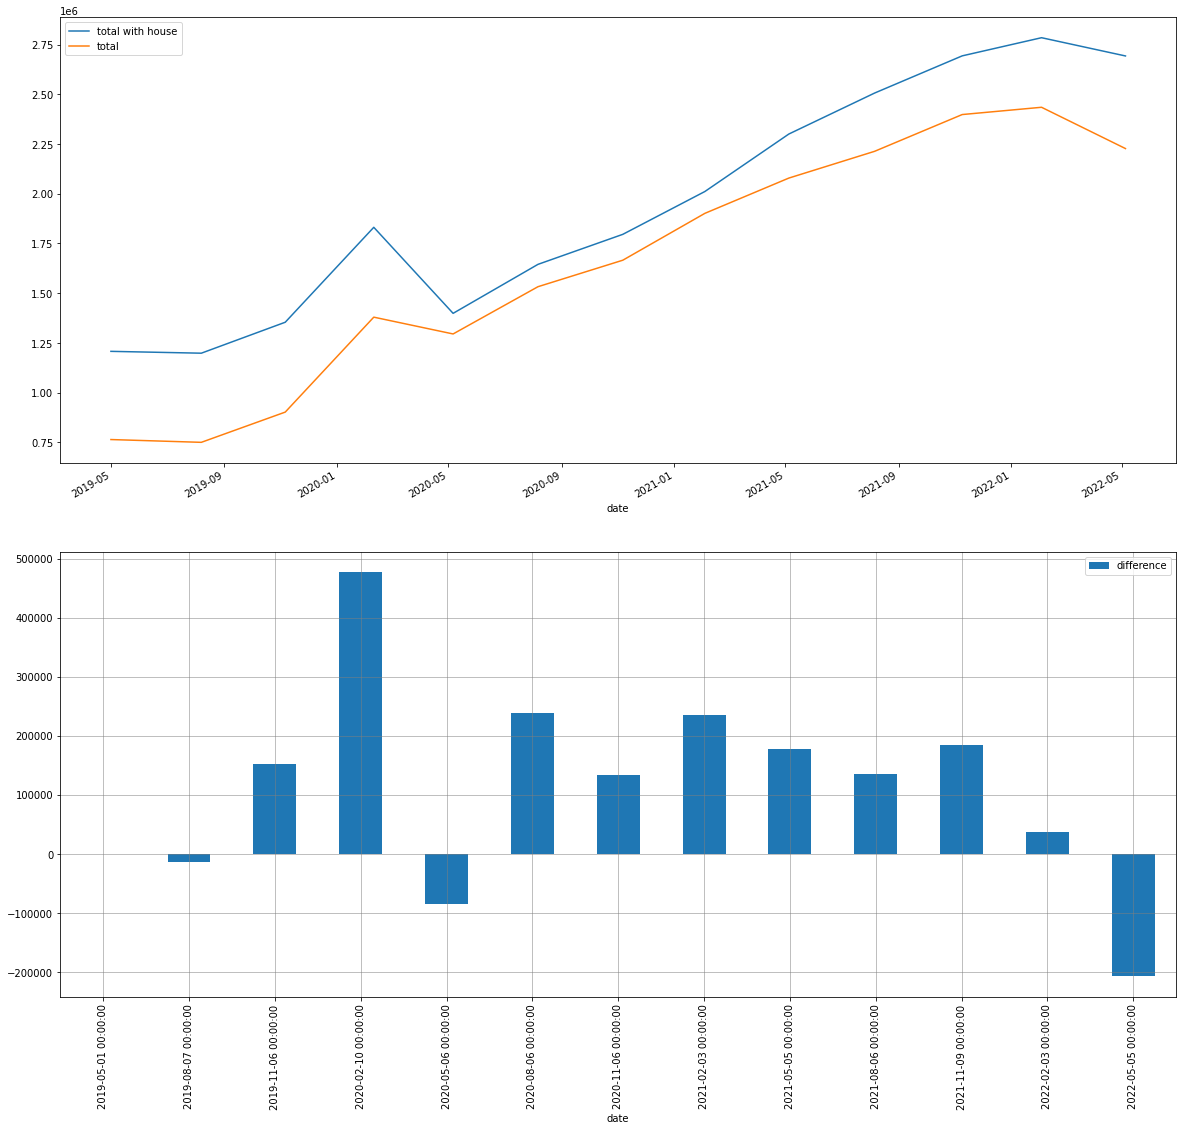

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

rows = []
rows.append({"date":"05/01/2019", "Wells cash":100260.40, "Wells credit":-1929.57, "chase credit":0.0,     "wells brokerage":20909.58, "fidelity":284004.18, "etrade":49422.75, "etrade stock":249679.65, 
"empower hannah":14593.43, "empower john":71455.34, "House value":1102000.00, "mortgage":-658366.50, "tithe":-24876.68})

rows.append({"date":"08/07/2019", "Wells cash":100689.28, "Wells credit":-329.74,  "chase credit":0.0,     "wells brokerage":20672.19, "fidelity":380078.53, "etrade":43028.98, "etrade stock":144660.80,
"empower hannah":14362.77, "empower john":78550.87, "House value":1102000.00, "mortgage":-653633.15, "tithe":-32218.83})

rows.append({"date":"11/06/2019", "Wells cash":58270.08, "Wells credit":0.00,     "chase credit":0.0,     "wells brokerage":20324.06, "fidelity":516164.05, "etrade":1941.79, "etrade stock":234587.60,
"empower hannah":15143.08, "empower john":93966.67, "House value":1102000.00, "mortgage":-650046.77, "tithe":-38781.82})

rows.append({"date":"02/10/2020", "Wells cash":53850.11, "Wells credit":0.00,     "chase credit":0.0,      "wells brokerage":20370.78, "fidelity":1015788.88, "etrade":1763.29, "etrade stock":204505.80,
"empower hannah":16206.57, "empower john":108802.06, "House value":1102000.00, "mortgage":-650046.77, "tithe":-42178.89})

rows.append({"date":"05/06/2020", "Wells cash":56692.33, "Wells credit":-269.45,   "chase credit":-1789.68, "wells brokerage":22450.00, "fidelity":847718.46, "etrade":2167.81,  "etrade stock":299564.10,
"empower hannah":13987.10, "empower john":98481.94, "House value":515000.00,  "mortgage":-411322.78, "tithe":-44378.09})

rows.append({"date":"08/06/2020", "Wells cash":46137.57, "Wells credit":0.00,     "chase credit":-2182.38,  "wells brokerage":24807.19, "fidelity":954744.14, "etrade":105017.35, "etrade stock":311637.24,
"empower hannah":16317.68, "empower john":123273.55, "House value":521693.00, "mortgage":-409280.11, "tithe":-47494.87})

rows.append({"date":"11/06/2020", "Wells cash":45168.12, "Wells credit":-214.66, "chase credit":-1663.29, "wells brokerage":25640.00, "fidelity":964813.58, "etrade":171603.54, "etrade stock":360115.46,
"empower hannah":16593.24, "empower john":133232.34, "House value":537331.00, "mortgage":-407220.79, "tithe":-49713.87})

rows.append({"date":"02/03/2021", "Wells cash":49157.78, "Wells credit":0.00,     "chase credit":-3773.34, "wells brokerage":28102.17, "fidelity":1212404.65, "etrade":144964.00, "etrade stock":329760.28,
"empower hannah":18813.23, "empower john":162068.47, "House value":515000,    "mortgage":-405144.70, "tithe":-40184.79})

rows.append({"date":"05/05/2021", "Wells cash":99890.90, "Wells credit":0.00,     "chase credit":-830.86,  "wells brokerage":31251.00, "fidelity":1324761.92, "etrade":45231.55, "etrade stock":399800.10,
"empower hannah":19662.01, "empower john":180939.49, "House value":624573.00, "mortgage":-403051.69, "tithe":-22053.44})

rows.append({"date":"08/06/2021", "Wells cash":92423.43, "Wells credit":0.00,    "chase credit":-5074.80,  "wells brokerage":28768.40, "fidelity":1407672.03, "etrade":16838.15, "etrade stock":472068.43,
"empower hannah":20508.15, "empower john":196907.71, "House value":694000.00, "mortgage":-400941.63, "tithe":-16856.93})

rows.append({"date":"11/09/2021", "Wells cash":83840.67, "Wells credit":0.00,   "chase credit":-3107.17,  "wells brokerage":28943.81, "fidelity":1480238.42, "etrade":14736.45, "etrade stock":585766.08,
"empower hannah":21213.00, "empower john":213646.38, "House value":694000.00, "mortgage":-398814.38, "tithe":-27061.92})

rows.append({"date":"02/03/2022", "Wells cash":80114.39, "Wells credit":0.00,    "chase credit":-2025.90,  "wells brokerage":27049.13, "fidelity":1398394.76, "etrade":16882.12, "etrade stock":685513.73,
"empower hannah":19732.53, "empower john":209110.90, "House value":746600,    "mortgage":-396669.80, "tithe":0.00})

rows.append({"date":"05/05/2022", "Wells cash":80610.18, "Wells credit":0.00,    "chase credit":0.00,      "wells brokerage":27031.94, "fidelity":1821888.93, "etrade":0.00,     "etrade stock":75539.83,
"empower hannah":19732.53, "empower john":202310.29, "House value":860300.00, "mortgage":-394507.75, "tithe":0.00})

net_worth = pd.DataFrame(rows)
net_worth["date"] = pd.to_datetime(net_worth["date"], format="%m/%d/%Y")
net_worth.set_index("date", drop=True, inplace=True)

nw_house_columns = ["Wells cash", "Wells credit", "chase credit", "wells brokerage", "fidelity", "etrade", "etrade stock","empower hannah", "empower john", "House value", "mortgage", "tithe"]
net_worth["total with house"] = net_worth[nw_house_columns].sum(axis=1)
nw_columns = ["Wells cash", "Wells credit", "chase credit", "wells brokerage", "fidelity", "etrade", "etrade stock","empower hannah", "empower john", "tithe"]
net_worth["total"] = net_worth[nw_columns].sum(axis=1)
net_worth["difference"] = 0.0
for row_idx in range(1,len(net_worth)):
    row_name = net_worth.iloc[row_idx].name
    net_worth.loc[row_name,"difference"] = net_worth.iloc[row_idx]["total"] - net_worth.iloc[row_idx-1]["total"]

display(net_worth)
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
_ = net_worth[["total with house","total"]].plot(legend=True, figsize=(20,20), ax=ax1)
_ = net_worth["difference"].plot.bar(legend=True, figsize=(20,20), ax=ax2)
ax2.grid(color='gray', linewidth=1, axis='both', alpha=0.5)



In [53]:
ax1.

135000